In [1]:
import os
os.chdir("../../")

import matplotlib.pyplot as plt
import pandas as pd
import datetime
import torch

from models.sabr_class import Sabr

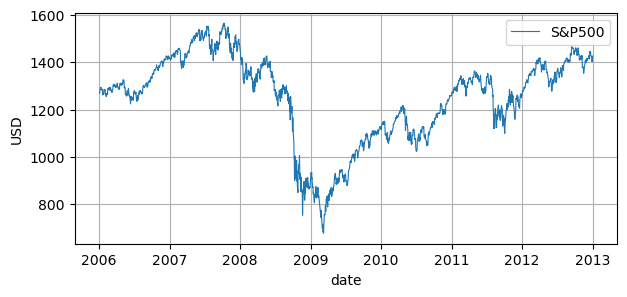

In [2]:
start = datetime.datetime.strptime('2006-01-03', '%Y-%m-%d')
end = datetime.datetime.strptime('2012-12-31', '%Y-%m-%d')

SPOT_PATH = 'data/spx_spot.csv'
spot_data = pd.read_csv(SPOT_PATH, sep=',')
spot_data['date'] = pd.to_datetime(spot_data['date'])
spot_data = spot_data[(spot_data['date'] >= start) & (spot_data['date'] <= end)]
spot_data.set_index('date', inplace=True)

S = spot_data['close'].to_numpy()
dates = spot_data.index.to_numpy()
S = torch.tensor(S, dtype=torch.float32)

plt.figure(figsize=(7, 3))
plt.plot(dates, S, label='S&P500', linewidth=0.8)
plt.ylabel("USD")
plt.xlabel("date")
plt.grid()
plt.legend()
plt.show()

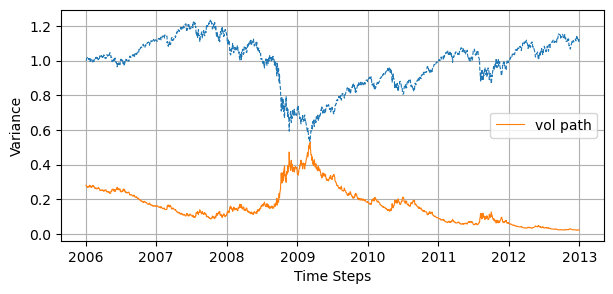

In [3]:
dt = torch.tensor(1/252, requires_grad=False)

mu = torch.tensor(-0.1)
beta = torch.tensor(1.0)
sigma = torch.tensor(0.5)
rho = torch.tensor(-0.8)
delta_0 = torch.tensor(10.0)

model = Sabr(mu, beta, sigma, rho, delta_0)
mu, beta, sigma, rho, delta_0 = model.inv_reparam()

plt.figure(figsize=(7, 3))
plt.plot(dates, S / S[0], linewidth=0.8, linestyle='--')

init_var, _ = model.variance_path(S, dt)
plt.plot(dates, torch.sqrt(init_var.detach()), linewidth=0.8, label='vol path')
plt.ylabel("Variance")
plt.xlabel("Time Steps")
plt.legend()
plt.grid()

Init params: mu: -0.010, beta: 1.000, sigma: 0.500, rho: -0.800, delta_0: 10.0
Init params: mu: -7.551223825430498e-05, beta: 0.934, sigma: 0.433, rho: -0.813, delta_0: 10.0


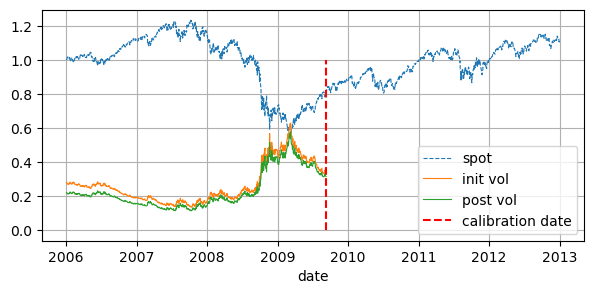

In [4]:
torch.manual_seed(1)

# Initial parameters
mu = torch.tensor(-0.01)
beta = torch.tensor(1.0)
sigma = torch.tensor(0.5)
rho = torch.tensor(-0.8)
delta_0 = torch.tensor(10.0)

model = Sabr(mu, beta, sigma, rho, delta_0)
mu, beta, sigma, rho, delta_0 = model.inv_reparam()
print(f"Init params: mu: {mu.item():.3f}, beta: {beta.item():.3f}, sigma: {sigma.item():.3f}, rho: {rho.item():.3f}, delta_0: {delta_0.item()}")

# Initial var path
t = len(S) // 2
t = 927

init_var, _ = model.variance_path(S[:t], dt)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
for epoch in range(100):
    #print(epoch)
    optimizer.zero_grad()
    loss = -model(S, t=t, delta_t=dt, window=1000)
    loss.backward()
    optimizer.step()

    #mu, beta, sigma, rho, delta_0 = model.inv_reparam()
    #print(f"epoch: {epoch}, mu: {mu.item()}, k: {k.item()}, theta: {theta.item()}, sigma: {sigma.item()}, rho: {rho.item()}, v0: {v0.item()}")
    #print(f"mu: {model.mu.grad.item()}, k: {model.l_k.grad.item()}, theta: {model.l_theta.grad.item()}, sigma: {model.l_sigma.grad.item()}, rho: {model.at_rho.grad.item()}")

mu, beta, sigma, rho, delta_0 = model.inv_reparam()
print(f"Init params: mu: {mu.item()}, beta: {beta.item():.3f}, sigma: {sigma.item():.3f}, rho: {rho.item():.3f}, delta_0: {delta_0.item()}")

# var path post calibration
post_var, _ = model.variance_path(S[:t], dt)

plt.figure(figsize=(7, 3))
plt.plot(dates, S / S[0], label='spot', linewidth=0.8, linestyle='--')
plt.plot(dates[:t], torch.sqrt(init_var.detach()), label='init vol', linewidth=0.8)
plt.plot(dates[:t], torch.sqrt(post_var.detach()), label='post vol', linewidth=0.8)
plt.vlines(dates[t], 0, 1, color='red', linestyle='--', label='calibration date')
plt.xlabel("date")
plt.grid()
plt.legend()
plt.show()

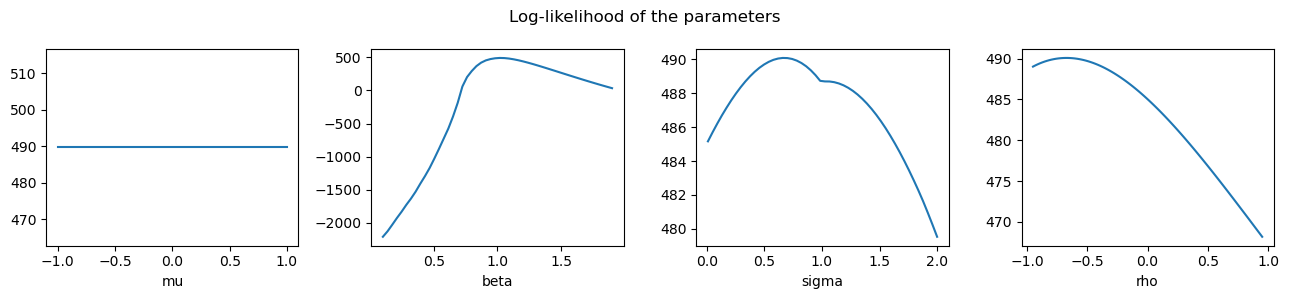

In [5]:
# Plot the likelihood slices

mu_true = torch.tensor(0.01)
beta_true = torch.tensor(1.0)
sigma_true = torch.tensor(0.5)
rho_true = torch.tensor(-0.5)
delta_0 = torch.tensor(10.0)

n_params = 4
fig, axs = plt.subplots(figsize=(13, 3), nrows=1, ncols=n_params)
window=200
t = len(S) // 2 - 200
t = 927

mus = torch.linspace(-1.0, 1.0, 50)
likelihood = torch.zeros_like(mus)
for i, mu in enumerate(mus):
    model = Sabr(mu, beta_true, sigma_true, rho_true, delta_0)
    likelihood[i] = model.forward(S, t=t, delta_t=dt, window=window)
axs[0].plot(mus, likelihood.detach(), label='log-likelihood')
axs[0].set_xlabel('mu')

betas = torch.linspace(0.1, 1.9, 50)
likelihood = torch.zeros_like(betas)
for i, beta in enumerate(betas):
    model = Sabr(mu_true, beta, sigma_true, rho_true, delta_0)
    likelihood[i] = model.forward(S, t=t, delta_t=dt, window=window)
axs[1].plot(betas, likelihood.detach(), label='log-likelihood')
axs[1].set_xlabel('beta')

sigmas = torch.linspace(0.01, 2.0, 50)
likelihood = torch.zeros_like(sigmas)
for i, sigma in enumerate(sigmas):
    model = Sabr(mu_true, beta_true, sigma, rho_true, delta_0)
    likelihood[i] = model.forward(S, t=t, delta_t=dt, window=window)
axs[2].plot(sigmas, likelihood.detach(), label='log-likelihood')
axs[2].set_xlabel('sigma')

rhos = torch.linspace(-0.95, 0.95, 100)
likelihood = torch.zeros_like(rhos)
for i, rho in enumerate(rhos):
    model = Sabr(mu_true, beta_true, sigma_true, rho, delta_0)
    likelihood[i] = model.forward(S, t=t, delta_t=dt, window=window)
axs[3].plot(rhos, likelihood.detach(), label='log-likelihood')
axs[3].set_xlabel('rho')

fig.suptitle('Log-likelihood of the parameters')
fig.tight_layout()
plt.show()